## CODE FRAGMENTS

In [1]:
from duckduckgo_search import DDGS
import numpy as np
import torch
import fastai.vision.all as fv
import fastbook as fb
from fastdownload import download_url
import os
from PIL import Image
from fastai.data.transforms import get_image_files
import fastai.data.transforms as fdt
from fastai.data.transforms import RandomSplitter, parent_label
from fastai.data.block import DataBlock
from fastai.vision.core import PILImage
from fastai.vision.data import ImageBlock, CategoryBlock
from fastai.vision.augment import Resize
from fastai.vision.learner import vision_learner
from torchvision.models.resnet import resnet18
from torchvision import models
from fastai.metrics import error_rate
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

import src.constants as cn


/Users/jlheller/home/Technical/repos/keras/ker/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
title_image = "https://media.licdn.com/dms/image/C4E12AQH78oMJgfgQ6Q/article-cover_image-shrink_600_2000/0/1520189708960?e=2147483647&v=beta&t=8lU11K2fNi5754j5QucWiemj_oF-KXZIhYgVijqKIHY"

# Acquiring images

In [3]:
 results = DDGS().images("bird", max_results=2)
results

[{'title': 'Colorful Parrot Bird, HD Birds, 4k Wallpapers, Images, Backgrounds ...',
  'image': 'http://hdqwalls.com/download/1/colorful-parrot-bird.jpg',
  'thumbnail': 'https://tse4.mm.bing.net/th?id=OIP.qLc7CKA1SnBvANPyTe5zeAHaEK&pid=Api',
  'url': 'http://hdqwalls.com/colorful-parrot-bird-wallpaper',
  'height': 2160,
  'width': 3840,
  'source': 'Bing'},
 {'title': '15 Amazing & Beautiful Bird Photos',
  'image': 'http://www.voidphase.com/media/2010/12/bird_gouldian_finch_1920.jpg',
  'thumbnail': 'https://tse4.mm.bing.net/th?id=OIP._oUvGnT7EaoC5XHrS7VbkwHaEK&pid=Api',
  'url': 'http://www.webmastergrade.com/15-amazing-beautiful-bird-photos/',
  'height': 1080,
  'width': 1920,
  'source': 'Bing'}]

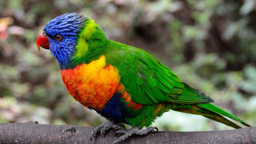

In [4]:
url = 'http://hdqwalls.com/download/1/colorful-parrot-bird.jpg'
dest = "birds/bird.jpg"
download_url(url, dest, show_progress=False)
BIRD_IMAGE = fv.Image.open(dest)
BIRD_IMAGE.to_thumb(256,256)

# Conversion between images and arrays

## Image -> Array

In [5]:
from PIL import Image
BIRD_IMAGE = Image.open('birds/bird.jpg')
 
# summarize some details about the image
print(BIRD_IMAGE.format)
print(BIRD_IMAGE.size)
print(BIRD_IMAGE.mode)

JPEG
(3840, 2160)
RGB


In [6]:
BIRD_ARR = np.asarray(BIRD_IMAGE)
np.shape(BIRD_ARR)

(2160, 3840, 3)

## Array-> Image

(2160, 3840, 3)
<class 'PIL.Image.Image'>
RGB
(3840, 2160)


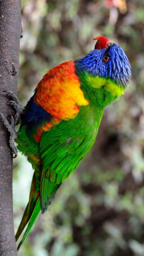

In [7]:

#  shape
print(BIRD_ARR.shape)
 
# Below is the way of creating Pillow 
# image from our numpyarray
pilImage = fv.Image.fromarray(BIRD_ARR)
print(type(pilImage))
 
# Let us check  image details
print(pilImage.mode)
print(pilImage.size)
pilImage.to_thumb(256, 256)
pilImage1 = pilImage.rotate(-90, expand=1)
pilImage1.to_thumb(256, 256)
#new_image = pilImage.resize((256, 256))
#new_image.save("image.png")

In [8]:
!open image.png

# Acquiring Birds and Planes

In [9]:
results[0]

{'title': 'Colorful Parrot Bird, HD Birds, 4k Wallpapers, Images, Backgrounds ...',
 'image': 'http://hdqwalls.com/download/1/colorful-parrot-bird.jpg',
 'thumbnail': 'https://tse4.mm.bing.net/th?id=OIP.qLc7CKA1SnBvANPyTe5zeAHaEK&pid=Api',
 'url': 'http://hdqwalls.com/colorful-parrot-bird-wallpaper',
 'height': 2160,
 'width': 3840,
 'source': 'Bing'}

In [10]:
# FIXME: Consider max_size (height * width)?
def getImage(key:str, directory=None, max_result=10, max_size=4000*4000):
    """
    Acquires images and places them in a directory
    """
    if directory is None:
        if " " in key:
            raise ValueError("Must specify valid directory path")
        else:
            directory = key
    # Do the search
    results = DDGS().images(key, max_results=max_result)
    # Download the files
    url = 'http://hdqwalls.com/download/1/colorful-parrot-bird.jpg'
    count = 0
    for dct in results:
        if "image" in dct:
            if ("width" in dct) and ("height" in dct):
                size = dct["width"]*dct["height"]
                if size > max_size:
                    continue
            url = dct["image"]
            file_path = os.path.join(directory, url.split("/")[-1])
            if os.path.isfile(file_path):
                continue              
            try:
                download_url(url, directory, show_progress=True)
                count += 1
            except:
                print("Download failed: %s" % url)
    return count

# Test
for ffile in os.listdir("test_images"):
    path = os.path.join("test_images", ffile)
    os.remove(path)
max_result = 2
count = getImage("plane", "test_images", max_result=max_result)
assert(count == max_result)
print("OK!")

OK!


In [11]:
if False:
    max_result = 2000
    getImage("plane", directory="planes", max_result=max_result)
    getImage("bird", directory="birds", max_result=max_result)


# Data Loader

In [12]:
if False:
    bad_dct = {}
    for directory in ["bird", "plane"]:
        dir_path = os.path.join(cn.DATA_DIR, directory)
        bad_dct[directory] = []
        for ffile in os.listdir(dir_path):
            path = os.path.join(dir_path, ffile)
            try:
                img = Image.open(path)
                _ = img.load()
            except Exception:
                bad_dct[directory].append(ffile)
                #os.remove(path)

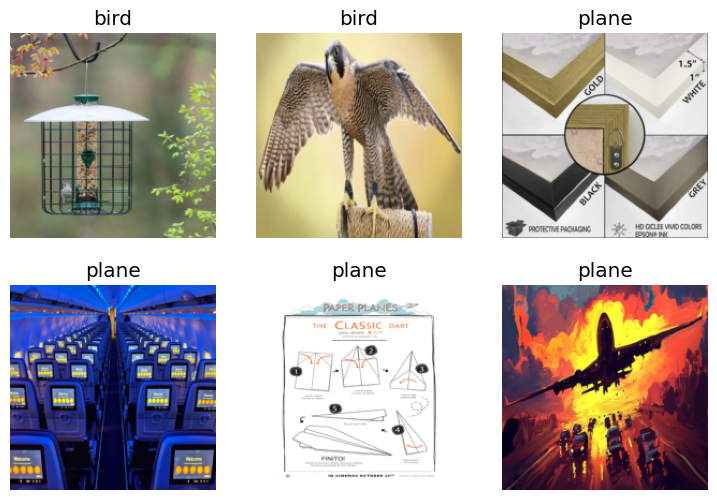

In [15]:
train_path = os.path.join(cn.DATA_DIR, "train")
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(train_path)

dls.show_batch(max_n=6)

In [16]:
#learn = vision_learner(dls, resnet18, metrics=error_rate)
learn = vision_learner(dls, models.efficientnet_v2_m, metrics=error_rate)
learn.fine_tune(3)

/Users/jlheller/home/Technical/repos/keras/ker/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/jlheller/home/Technical/repos/keras/ker/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=EfficientNet_V2_M_Weights.IMAGENET1K_V1`. You can also use `weights=EfficientNet_V2_M_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.681909,0.415863,0.150000,00:39


/Users/jlheller/home/Technical/repos/keras/ker/lib/python3.9/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.409500,0.363758,0.122222,00:44
1,0.305198,0.183560,0.072222,00:43
2,0.283726,0.184785,0.077778,00:44


In [20]:
test_path = os.path.join(cn.DATA_DIR, "test")
pics = ["larry_bird.png", "big_bird.png", "airplane.png", "jacko.png", "dice.png", "sunset.png"]
result_dct = {}
for pic in pics:
    is_bird,mm,probs = learn.predict(PILImage.create((path)))
    result_dct[pic] = is_bird, mm, probs
result_dct

{'larry_bird.png': ('plane', tensor(1), tensor([0.0748, 0.9252])),
 'big_bird.png': ('plane', tensor(1), tensor([0.0748, 0.9252])),
 'airplane.png': ('plane', tensor(1), tensor([0.0748, 0.9252])),
 'jacko.png': ('plane', tensor(1), tensor([0.0748, 0.9252])),
 'dice.png': ('plane', tensor(1), tensor([0.0748, 0.9252])),
 'sunset.png': ('plane', tensor(1), tensor([0.0748, 0.9252]))}

In [ ]:
dir(models)

# Convert to same image format?

# Train

Workflow
1. Convert to png and resize
2. Train with initial data
3. Poor accuracy. Try removing bad data.
4. Try data augmentation.

# Use GPUs

In [1]:
import tensorflow as tf
if False:
    cifar = tf.keras.datasets.cifar100
    (x_train, y_train), (x_test, y_test) = cifar.load_data()
    model = tf.keras.applications.ResNet50(
        include_top=True,
        weights=None,
        input_shape=(32, 32, 3),
        classes=100,)
    
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)
    model.compile(optimizer="adam", loss=loss_fn, metrics=["accuracy"])
    model.fit(x_train, y_train, epochs=5, batch_size=64)

/Users/jlheller/home/Technical/repos/keras/ker/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


169001437/169001437 ━━━━━━━━━━━━━━━━━━━━ 15s 0us/step
Epoch 1/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1433s 2s/step - accuracy: 0.0595 - loss: 4.5939
Epoch 2/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1982s 3s/step - accuracy: 0.1145 - loss: 4.0178
Epoch 3/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1665s 2s/step - accuracy: 0.1269 - loss: 3.8717
Epoch 4/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 5800s 7s/step - accuracy: 0.1561 - loss: 3.7047
Epoch 5/5
782/782 ━━━━━━━━━━━━━━━━━━━━ 1535s 2s/step - accuracy: 0.1707 - loss: 3.6629
